In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)
  
#read the files
test = pd.read_csv("test_results.csv")
print(test.head())

   user_id            timestamp          source  device operative_system  test  price  converted
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS     0     39          0
1   624057  2015-05-10 21:08:46      seo-google  mobile          android     0     39          0
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android     0     39          0
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS     1     59          0
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac     0     39          0


In [2]:
user = pd.read_csv("user_table.csv")
print(user.head())

   user_id         city country    lat    long
0   510335      Peabody     USA  42.53  -70.97
1    89568         Reno     USA  39.54 -119.82
2   434134       Rialto     USA  34.11 -117.39
3   289769  Carson City     USA  39.15 -119.74
4   939586      Chicago     USA  41.84  -87.68


In [3]:
# check missing values
print(test.isnull().sum())

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64


In [4]:
print(user.isnull().sum())

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64


In [5]:
#join the two datasets on user_id
data=pd.merge(left=test, right=user, how='left', on='user_id')

print(data.head())

   user_id            timestamp          source  device operative_system  ...  converted          city  country    lat   long
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS  ...          0       Buffalo      USA  42.89 -78.86
1   624057  2015-05-10 21:08:46      seo-google  mobile          android  ...          0     Lakeville      USA  44.68 -93.24
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android  ...          0         Parma      USA  41.38 -81.73
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS  ...          0  Fayetteville      USA  35.07 -78.90
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac  ...          0       Fishers      USA  39.95 -86.02

[5 rows x 12 columns]


 ## check if people in test always get the 59 dollars and people in control 39 dollars

In [7]:
print(data[['user_id','test','price']].groupby(['test','price']).count())

            user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918


There are some issues. A small number of users appear to be getting the wrong price based on their test/control assignment.
As the number here is pretty small, we can just remove them and move one with our analysis. However, this should be investigated further in case there is some bigger bug that might be impacting something else.

In [8]:
data=data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]
print(data[['user_id','test','price']].groupby(['test','price']).count())

            user_id
test price         
0    39      202517
1    59      113918


In [9]:
# create the revenue variable
data['revenue']=data['converted']*data['price']

print(data['revenue'].describe())

count    316435.000000
mean          0.827083
std           6.179009
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          59.000000
Name: revenue, dtype: float64


## Should the company sell its software for 39 or 59?

In [10]:
# compare conversion rate
print(data[['converted','test']].groupby('test').mean())


      converted
test           
0      0.019900
1      0.015555


In [11]:
#Check avg revenue per user
print(data[['revenue','test']].groupby('test').mean())

       revenue
test          
0     0.776083
1     0.917748


In [12]:
# Check avg revenue per user
# check if this is statistically significant
print(ttest_ind(data[data['test']==1]['revenue'], data[data['test']==0]['revenue'], equal_var=False))
# this is significant

Ttest_indResult(statistic=5.715224666463108, pvalue=1.0972577312420781e-08)


## How much different users are valuing our product?

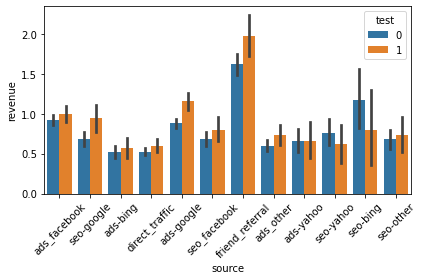

In [14]:
sns.barplot(x='source', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()
# Most segments agree with the overall finding of an increase in revenue as we increase price

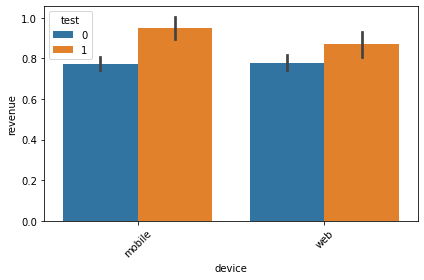

In [15]:
sns.barplot(x='device', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()
# mobile users are less price sensitive.

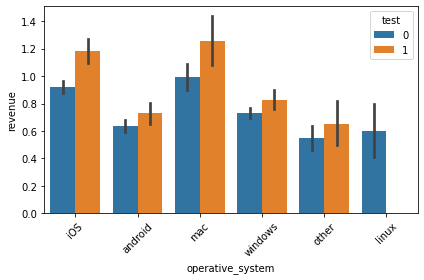

In [16]:
sns.barplot(x='operative_system', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()
# mac/iOS react better to the price increase